In [221]:
# packages

import importlib_resources
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import svd
from itertools import combinations
import xlrd
from matplotlib.patches import Ellipse
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import zscore

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from dtuimldmtools import rlr_validate
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_predict, KFold
from sklearn.neural_network import MLPRegressor

import os
os.chdir(os.path.abspath(''))

In [213]:
filename = 'Raisin_Dataset.xls'
doc = xlrd.open_workbook(filename).sheet_by_index(0)


attributeNames = doc.row_values(0, 0, 7)

classLabels = doc.col_values(7, 1, 901)
classNames = sorted(set(classLabels))
classDict = dict(zip(classNames, range(len(classNames))))

# Extract vector y, convert to NumPy array
y = np.asarray([classDict[value] for value in classLabels])

# Preallocate memory, then extract excel data to matrix X
X = np.empty((900, 7))
for i, col_id in enumerate(range(0, 7)):
    X[:, i] = np.asarray(doc.col_values(col_id, 1, 901))

# Compute values of N, M and C
N = len(y)
M = len(attributeNames)
C = len(classNames)

print(f'matrix size: {N} by {M}')
print(attributeNames)
print(classNames)

print(y[449])
print(y[899])


# set area as y and remove it from the data set
y_1ofkcoding = np.zeros((len(y),2))
y_1ofkcoding[:,0] = y
y_1ofkcoding[:,1] = 1-y


limit = 449
# first class
#y = X[:limit,0]
#X = X[:limit,1:]
## second class
#y = X[limit:,0]
#X = X[limit:,1:]

# only ['MajorAxisLength', 'MinorAxisLength', 'Eccentricity']
#y = X[:,0]
#X = X[:,1:4]
#attributeNames = attributeNames[1:4]

# y = AREA
#y = X[:,1]
#X = X[:,1:]
#attributeNames = attributeNames[1:]

# y = ECCENTRICITY
#y = X[:,3]
#X = np.delete(X, 3, axis=1)
#attributeNames.pop(3)

# eccentricity and first class
selected_feature = attributeNames[3]
y = X[:limit,3]
X = np.delete(X, 3, axis=1)
X = X[:limit,:]
attributeNames.pop(3)


matrix size: 900 by 7
['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'ConvexArea', 'Extent', 'Perimeter']
['Besni', 'Kecimen']
1
0


'Eccentricity'

## REGRESSION

set y equal to the AREA to have a continuous output
remove it from the x

In [209]:
# Compute values of N, M and C
N = len(y)
M = len(attributeNames)
C = len(classNames)

print(f'matrix size: {N} by {M}')
print(attributeNames)
print(classNames)
print('selected: ', selected_feature)

#print('no transformation', X[0])

# regularization
mu = np.mean(X, 0)
sigma = np.std(X, 0)
X = (X - mu) / sigma

mu2 = np.mean(y)
sigma2 = np.std(y)
y = (y - mu2) / sigma2

# Add offset attribute
X = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
attributeNames = ["Offset"] + attributeNames
M = M + 1

#print('after transformation', X[0])

matrix size: 449 by 6
['Area', 'MajorAxisLength', 'MinorAxisLength', 'ConvexArea', 'Extent', 'Perimeter']
['Besni', 'Kecimen']
selected:  Eccentricity


# PART a

optimal lambda = 0.09540954763499938 with error = 0.20100205562212334
Weights:
	Offset              : 0.00000
	Area                : 2.62734
	MajorAxisLength     : 0.90749
	MinorAxisLength     : -1.21647
	ConvexArea          : -2.66592
	Extent              : 0.00195
	Perimeter           : 0.64491


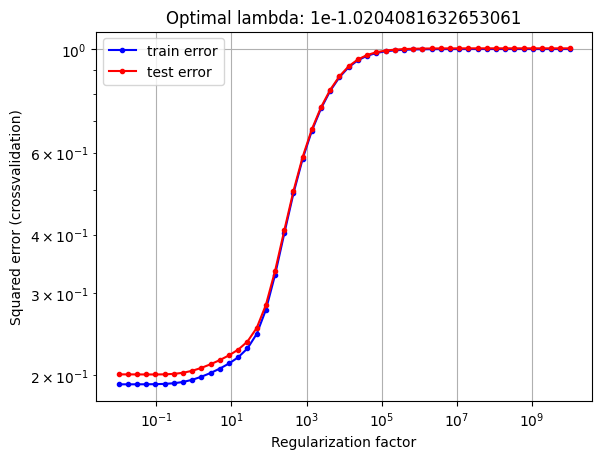

In [147]:
# using rlr_validate


# parameters
#lambdas = np.power(10.0, range(-5, 9))
lambdas = np.logspace(-2, 10, 50)
cross_validation = 10
XtX = X.T @ X
Xty = X.T @ y

(   opt_val_err,
    opt_lambda,
    mean_w_vs_lambda,
    train_err_vs_lambda,
    test_err_vs_lambda,
    ) = rlr_validate(X, y, lambdas, cross_validation)

lambdaI = opt_lambda * np.eye(M)
lambdaI[0, 0] = 0  # Do no regularize the bias term
w_rlr= np.linalg.solve(XtX + lambdaI, Xty).squeeze()
print(f'optimal lambda = {opt_lambda} with error = {opt_val_err}')

print("Weights:")
for m in range(M):
    print(f'\t{attributeNames[m].ljust(20)}: {w_rlr[m]:.5f}')

plt.figure()
plt.title("Optimal lambda: 1e{0}".format(np.log10(opt_lambda)))
plt.loglog(lambdas, train_err_vs_lambda.T, "b.-", label='train error')
plt.loglog(lambdas, test_err_vs_lambda.T, "r.-", label='test error')
plt.xlabel("Regularization factor")
plt.ylabel("Squared error (crossvalidation)")
plt.legend()
plt.grid()


plt.show()

Optimal lambda: 0.01
Weights:
	Offset              : 0.00000
	Area                : 2.62734
	MajorAxisLength     : 0.90749
	MinorAxisLength     : -1.21647
	ConvexArea          : -2.66592
	Extent              : 0.00195
	Perimeter           : 0.64491


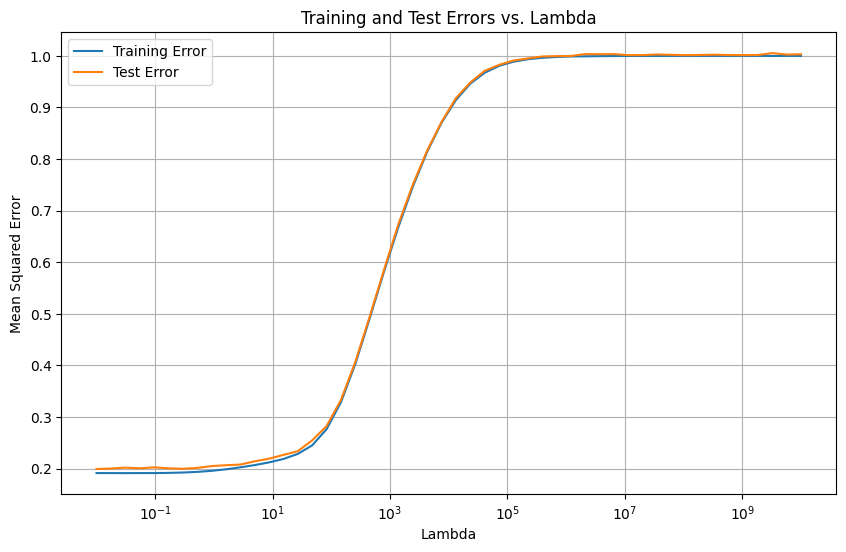

In [148]:
# changing the solution method but same result

# parameters
K = 10
CV = model_selection.KFold(n_splits=K, shuffle=True)
lambdas = np.logspace(-2, 10, 50)

# Initialize arrays to store errors
Error_train = np.zeros(len(lambdas))
Error_test = np.zeros(len(lambdas))

# Loop over lambda values
for i, lambda_val in enumerate(lambdas):
    # Initialize arrays to store fold errors
    fold_train_errors = []
    fold_test_errors = []
    
    # Perform cross-validation
    for train_index, test_index in CV.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train Ridge regression model with current lambda value
        model = Ridge(alpha=lambda_val)
        model.fit(X_train, y_train)

        # Compute training error
        train_error = np.mean((y_train - model.predict(X_train))**2)
        fold_train_errors.append(train_error)

        # Compute test error
        test_error = np.mean((y_test - model.predict(X_test))**2)
        fold_test_errors.append(test_error)

    # Average fold errors
    Error_train[i] = np.mean(fold_train_errors)
    Error_test[i] = np.mean(fold_test_errors)



optimal_lambda_index = np.argmin(Error_test)
optimal_lambda = lambdas[optimal_lambda_index]

print(f'Optimal lambda: {optimal_lambda}')


model = Ridge(alpha=optimal_lambda)
model.fit(X, y)

# Get the weights of the parameters
weights = model.coef_

print("Weights:")
for m in range(M):
    print(f'\t{attributeNames[m].ljust(20)}: {w_rlr[m]:.5f}')


# Plot training and test errors
plt.figure(figsize=(10, 6))
plt.semilogx(lambdas, Error_train, label='Training Error')
plt.semilogx(lambdas, Error_test, label='Test Error')
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error')
plt.title('Training and Test Errors vs. Lambda')
plt.legend()
plt.grid(True)
plt.show()



# PART B

In [227]:
def compute_error_rate(y_true, y_pred):
    return np.sum(y_true - y_pred)**2 / len(y_true)


cv = model_selection.KFold(n_splits=5, shuffle=True)
outer_results = []
nodes_range = range(1, 11)
ANN_results = {'nodes': [], 'error': []}


# GridSearchCV for Logistic Regression and KNN at the same time
for i, (train_index, test_index) in enumerate(cv.split(X, y), start=1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Linear Regression with GridSearch
    lin_reg = Ridge()
    param_grid_lin_reg = {'alpha': [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18]}
    #param_grid_lin_reg = {'alpha': [0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18, 0.18, 0.20, 0.22, 0.24, 0.26, 0.28, 0.30, 0.32, 0.34, 0.36, 0.38, 0.40, 0.42, 0.44]}
    #param_grid_lin_reg = {'alpha': [0.001, 0.010, 0.015, 0.020, 0.025, 0.030, 0.035, 0.040, 0.045, 0.050]}
    grid_search_lin_reg = GridSearchCV(lin_reg, param_grid_lin_reg, cv=10)
    grid_search_lin_reg.fit(X_train, y_train)
    best_lin_reg = grid_search_lin_reg.best_estimator_
    best_lin_reg.fit(X_train, y_train)
    y_pred_lin_reg = best_lin_reg.predict(X_test)

    ## ANN
    for h in nodes_range:
        # Initialize error list for each h
        errors = []
        
        # Inner cross-validation
        for train_index, test_index in cv.split(X_train, y_train):
            X_train_in, X_test_in = X[train_index], X[test_index]
            y_train_in, y_test_in = y[train_index], y[test_index]
            
            # Create and train MLPRegressor with 1 hidden layer and h nodes
            mlp = MLPRegressor(hidden_layer_sizes=(h,), max_iter=2000)
            mlp.fit(X_train_in, y_train_in)
            
            # Predictions
            y_pred_ANN = mlp.predict(X_test_in)
            
            # Calculate mean squared error
            error_rate_ANN = compute_error_rate(y_test_in, y_pred_ANN)
            errors.append(error_rate_ANN)
        
        # Store average error for this h
        ANN_results['nodes'].append(h)
        ANN_results['error'].append(np.mean(errors))

    optimal_nodes = ANN_results['nodes'][np.argmin(ANN_results['error'])]
    min_error = np.min(ANN_results['error'])


    #Evaluation Baseline
    y_pred_baseline = np.ones(len(y_test))*np.mean(y_train)

    # Error rates
    error_rate_lin_reg = compute_error_rate(y_test, y_pred_lin_reg)
    error_rate_baseline = compute_error_rate(y_test, y_pred_baseline)
    
    #Results

    outer_results.append({
        'Outer_Fold': i,
        'ANN_Param': optimal_nodes,
        'ANN_Error': min_error * 100,
        'LogReg_C_Param': grid_search_lin_reg.best_params_['alpha'],
        'LogReg_Error': error_rate_lin_reg * 100,
        'Baseline_Error': error_rate_baseline * 100
    })


#Display
results_panda = pd.DataFrame(outer_results) #Using Panda Dataframe to print
print(results_panda)




d:\anaconda\envs\myenv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\anaconda\envs\myenv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\anaconda\envs\myenv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\anaconda\envs\myenv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\anaconda\envs\myenv\Lib\site-packages\sklearn\neural_network\_multilayer_

   Outer_Fold  ANN_Param    ANN_Error  LogReg_C_Param  LogReg_Error  \
0           1          1  6294.657128            0.02      0.206502   
1           2          1  6294.657128            0.18      0.231207   
2           3          2  1969.654999            0.18      0.199383   
3           4          2  1969.654999            0.18      0.175275   
4           5          1  1834.278265            0.18      0.018042   

   Baseline_Error  
0        0.004947  
1        0.097234  
2        0.336196  
3        0.081306  
4        0.289091  
